In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import time

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
mean = 0.
std = 0.
for images, _ in trainloader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(trainloader.dataset)
std /= len(trainloader.dataset)

print(mean, std)


mean = 0.
std = 0.
for images, _ in testloader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(testloader.dataset)
std /= len(testloader.dataset)

print(mean, std)

tensor([-0.0172, -0.0357, -0.1069]) tensor([0.4046, 0.3988, 0.4019])
tensor([-0.0116, -0.0297, -0.0992]) tensor([0.4040, 0.3982, 0.4023])


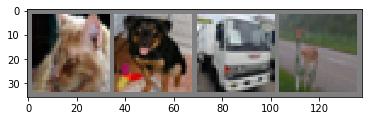

  cat   dog truck  deer


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.resnet50 = models.resnet50(pretrained = True)
        self.fc1 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.resnet50(x)
        x = self.fc1(x)
        return x

net = Net()
#Check if freezing works
#print(list(filter(lambda p: p.requires_grad, net.parameters())))

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001) #Don't know if you have to have filter
#optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.0001)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
#torch.cuda.device_count()
net.to(device)

cuda:0


Net(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [8]:
numEpoch = 2
start_time = time.time()

for epoch in range(numEpoch):  # loop over the dataset multiple times

    running_loss = 0.0
    size = len(trainloader)
    print(size)
    size = 50
    running_correct = 0
    running_total = 0
    for i, data in enumerate(trainloader, 0):
        correct = 0
        total = 0
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        running_total += total
        running_correct += correct

        # print statistics
        running_loss += loss.item()
        if i % size == size-1:    # print every 50 batch
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / size))
            running_loss = 0.0
            
            print('Train accuracy: %d %%' % (
    100 * running_correct / running_total))
            running_correct = 0
            running_total = 0

print('Finished Training')

print("--- %s seconds ---" % (time.time() - start_time))
print ("--- %s seconds/epoc ---" % ((time.time() - start_time)/numEpoch))

391
[1,    50] loss: 1.908
Train accuracy: 36 %
[1,   100] loss: 1.183
Train accuracy: 58 %
[1,   150] loss: 0.981
Train accuracy: 65 %
[1,   200] loss: 0.889
Train accuracy: 68 %
[1,   250] loss: 0.813
Train accuracy: 71 %
[1,   300] loss: 0.744
Train accuracy: 74 %
[1,   350] loss: 0.673
Train accuracy: 76 %
391
[2,    50] loss: 0.461
Train accuracy: 84 %
[2,   100] loss: 0.450
Train accuracy: 84 %
[2,   150] loss: 0.462
Train accuracy: 84 %
[2,   200] loss: 0.453
Train accuracy: 84 %
[2,   250] loss: 0.457
Train accuracy: 84 %
[2,   300] loss: 0.452
Train accuracy: 84 %
[2,   350] loss: 0.483
Train accuracy: 83 %
Finished Training
--- 81.86231708526611 seconds ---
--- 40.93119955062866 seconds/epoc ---


In [9]:
PATH = './CIFAR10.pth'

In [10]:
torch.save(net.state_dict(), PATH)

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
start_time = time.time()

net.to(device)
correct = 0
total = 0

nb_classes = 10
confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
print(confusion_matrix.int())

print("--- %s seconds ---" % (time.time() - start_time))
print ("--- %s seconds/test ---" % ((time.time() - start_time)/total))

Accuracy of the network on the test images: 80 %
tensor([[862,  18,  25,  13,  11,   2,   9,   3,  36,  21],
        [ 10, 893,   0,   3,   1,   3,  11,   0,   9,  70],
        [ 57,   1, 709,  48,  76,  26,  56,  14,   7,   6],
        [ 14,   8,  33, 675,  45, 106,  73,  19,  10,  17],
        [ 19,   2,  44,  38, 784,  26,  35,  45,   4,   3],
        [  8,   1,  23, 204,  34, 680,  16,  25,   1,   8],
        [  5,   5,  12,  39,  30,   5, 896,   5,   1,   2],
        [ 27,   4,  13,  54,  48,  48,   7, 790,   1,   8],
        [ 52,  31,   8,  12,   4,   0,   3,   1, 875,  14],
        [ 22,  79,   4,  15,   1,   0,   5,   3,   9, 862]], dtype=torch.int32)
--- 1.922990322113037 seconds ---
--- 0.00019230549335479737 seconds/test ---


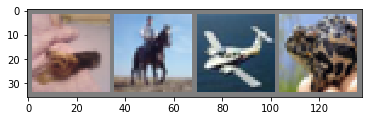

GroundTruth:    dog horse plane  frog
Predicted:    car horse plane truck


In [13]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=True, num_workers=0)

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))